In [1]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [2]:
def load_ravdess_speech(data_path):
    filepaths = []
    emotions = []
    actors = []

    emotion_dict = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    for folder in sorted(os.listdir(data_path)):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            for file in glob.glob(os.path.join(folder_path, "*.wav")):
                filename = os.path.basename(file)
                parts = filename.split('-')
                if len(parts) != 7:
                    continue  # skip invalid filenames
                modality = parts[1]
                emotion_code = parts[2]
                actor = parts[-1].split('.')[0]

                if modality == '01':
                    emotion_label = emotion_dict.get(emotion_code)
                    if emotion_label:
                        filepaths.append(file)
                        emotions.append(emotion_label)
                        actors.append(actor)

    return pd.DataFrame({'filepath': filepaths, 'emotion': emotions, 'actor': actors})

DATA_PATH = 'Dataset_Ravdess'
df = load_ravdess_speech(DATA_PATH)
print("✅ Total samples found:", len(df))
print(df['emotion'].value_counts())


✅ Total samples found: 1440
emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


In [3]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr, n_steps=n_steps)

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def apply_random_augmentation(y, sr):
    choice = random.choice(['none', 'noise', 'pitch', 'stretch'])
    if choice == 'noise':
        return add_noise(y)
    elif choice == 'pitch':
        return pitch_shift(y, sr)
    elif choice == 'stretch':
        return time_stretch(y)
    return y

def extract_augmented_features(df, n_mfcc=40, max_pad_len=174):
    features = []
    labels = []

    for _, row in df.iterrows():
        try:
            y, sr = librosa.load(row['filepath'], res_type='kaiser_fast')
            for _ in range(3):  # 1 original + 2 augmented
                y_aug = apply_random_augmentation(y, sr)
                mfcc = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=n_mfcc)

                if mfcc.shape[1] < max_pad_len:
                    pad_width = max_pad_len - mfcc.shape[1]
                    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :max_pad_len]

                features.append(mfcc)
                labels.append(row['emotion'])

        except Exception as e:
            print("❌ Error on file:", row['filepath'])

    return np.array(features), np.array(labels)

X, y = extract_augmented_features(df)
print("✅ Feature shape (before reshape):", X.shape)


C:\Users\ipg 3\AppData\Local\Temp\ipykernel_24876\436412260.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sr, n_steps=n_steps)
C:\Users\ipg 3\AppData\Local\Temp\ipykernel_24876\436412260.py:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)


✅ Feature shape (before reshape): (4320, 40, 174)


In [4]:
# Reshape for GRU
X = X[..., np.newaxis].squeeze(-1)  # (samples, 40, 174) → (samples, 174, 40)
X = np.transpose(X, (0, 2, 1))

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42
)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_encoded),
                                     y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))


In [5]:
def attention_layer(inputs):
    score = Dense(1, activation='tanh')(inputs)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * inputs
    return tf.reduce_sum(context_vector, axis=1)

inputs = Input(shape=(174, 40))

x = Bidirectional(GRU(128, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(GRU(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174, 40)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 174, 256)     130560      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 174, 256)    1024        ['bidirectional[0][0]']          
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 174, 256)     0           ['batch_normalization[0][0]']

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_gru_attention_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/100
108/108 [==============================] - 42s 338ms/step - loss: 1.7221 - accuracy: 0.3304 - val_loss: 1.7725 - val_accuracy: 0.3484
Epoch 2/100
108/108 [==============================] - 32s 293ms/step - loss: 1.3933 - accuracy: 0.4708 - val_loss: 1.3937 - val_accuracy: 0.4792
Epoch 3/100
108/108 [==============================] - 31s 289ms/step - loss: 1.1929 - accuracy: 0.5677 - val_loss: 1.1273 - val_accuracy: 0.5880
Epoch 4/100
108/108 [==============================] - 31s 291ms/step - loss: 1.0363 - accuracy: 0.6172 - val_loss: 1.0151 - val_accuracy: 0.6308
Epoch 5/100
108/108 [==============================] - 31s 290ms/step - loss: 0.9292 - accuracy: 0.6557 - val_loss: 1.0649 - val_accuracy: 0.6262
Epoch 6/100
108/108 [==============================] - 31s 291ms/step - loss: 0.7968 - accuracy: 0.7188 - val_loss: 0.9396 - val_accuracy: 0.6400
Epoch 7/100
108/108 [==============================] - 31s 290ms/step - loss: 0.7124 - accuracy: 0.7465 - val_loss: 0.9535 -

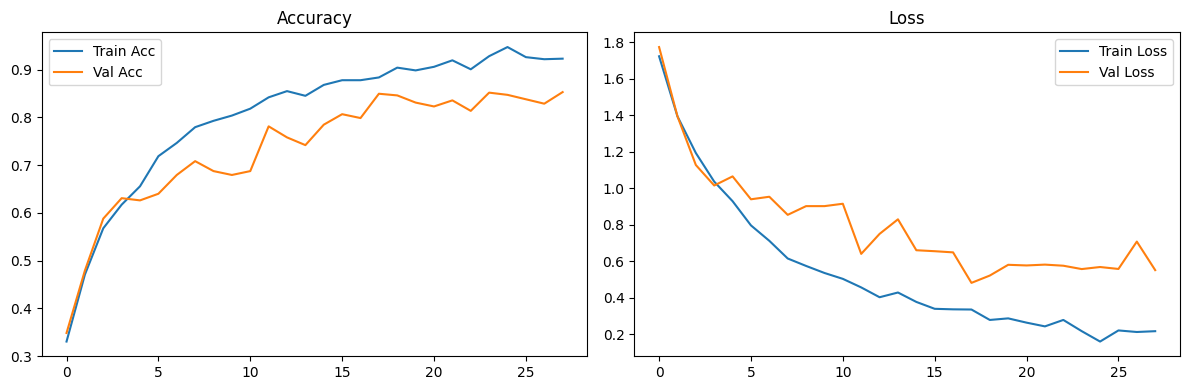

In [7]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


27/27 [==============================] - 3s 80ms/step
🔍 Macro F1 Score: 84.32 %

📊 Classification Report:

              precision    recall  f1-score   support

       angry       0.94      0.90      0.92       115
        calm       0.92      0.85      0.88       115
     disgust       0.79      0.91      0.85       115
     fearful       0.87      0.87      0.87       115
       happy       0.89      0.80      0.84       115
     neutral       0.68      0.83      0.74        58
         sad       0.76      0.70      0.73       115
   surprised       0.90      0.92      0.91       116

    accuracy                           0.85       864
   macro avg       0.84      0.85      0.84       864
weighted avg       0.85      0.85      0.85       864



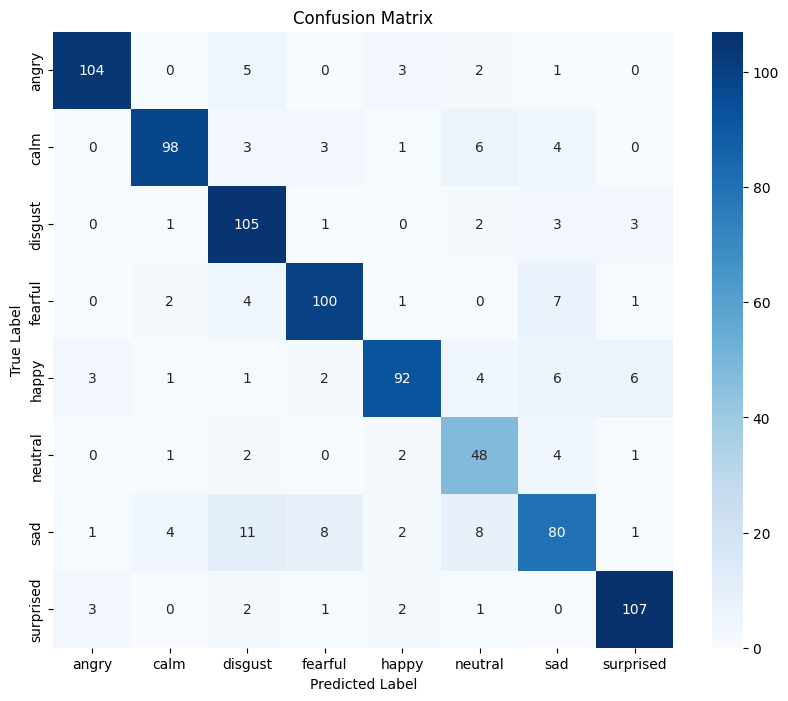

In [8]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
print("🔍 Macro F1 Score:", round(f1 * 100, 2), "%\n")

print("📊 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [9]:
# Save the trained model
model.save("emotion_gru_attention_model.h5")

# Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Model and label encoder saved!")


✅ Model and label encoder saved!
